<a href="https://colab.research.google.com/github/Niranjan-Kumar2001/Exercise/blob/main/SARIMAX_Sales_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SARIMAX Model - Superstore Data Analysis

In [1]:
!wget https://community.tableau.com/docs/DOC-1236

--2022-04-06 13:31:16--  https://community.tableau.com/docs/DOC-1236
Resolving community.tableau.com (community.tableau.com)... 13.109.212.160
Connecting to community.tableau.com (community.tableau.com)|13.109.212.160|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://community.tableau.com/s/question/0D54T00000CWeX8SAL [following]
--2022-04-06 13:31:16--  https://community.tableau.com/s/question/0D54T00000CWeX8SAL
Reusing existing connection to community.tableau.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://community.tableau.com/s/question/0D54T00000CWeX8SAL/sample-superstore-sales-excelxls [following]
--2022-04-06 13:31:16--  https://community.tableau.com/s/question/0D54T00000CWeX8SAL/sample-superstore-sales-excelxls
Reusing existing connection to community.tableau.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘DOC-1236’

DOC-1236             

In [2]:
# data from https://community.tableau.com/docs/DOC-1236
!ls

DOC-1236  sample_data


> **xlrd => Excel Read**. <br>To read spreadsheets

In [3]:
!pip install pandas==1.2.0
!pip install --upgrade xlrd

     |████████████████████████████████| 9.9 MB 4.4 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
     |████████████████████████████████| 96 kB 3.1 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


In [6]:
import pandas as pd
df = pd.read_excel('Sample - Superstore.xls')
df.head()
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [9]:
import warnings
import itertools
import numpy as np
import statsmodels.api as sm # for plotting decomposition graphs
import matplotlib.pyplot as plt # for plotting graphs
import matplotlib


warnings.filterwarnings("ignore")
# for production use, we may want to supress the warning

In [10]:
df.head(2)

Row ID        Order ID Order Date  Ship Date     Ship Mode Customer ID  \
0       1  CA-2016-152156 2016-11-08 2016-11-11  Second Class    CG-12520   
1       2  CA-2016-152156 2016-11-08 2016-11-11  Second Class    CG-12520   

  Customer Name   Segment        Country       City  ... Postal Code  Region  \
0   Claire Gute  Consumer  United States  Henderson  ...       42420   South   
1   Claire Gute  Consumer  United States  Henderson  ...       42420   South   

        Product ID   Category Sub-Category  \
0  FUR-BO-10001798  Furniture    Bookcases   
1  FUR-CH-10000454  Furniture       Chairs   

                                        Product Name   Sales  Quantity  \
0                  Bush Somerset Collection Bookcase  261.96         2   
1  Hon Deluxe Fabric Upholstered Stacking Chairs,...  731.94         3   

   Discount    Profit  
0       0.0   41.9136  
1       0.0  219.5820  

[2 rows x 21 columns]

In [11]:
colNames = df.columns 
for i, feature in enumerate(colNames):
  print(colNames[i] + " " + str(len(df[feature].value_counts())))

Row ID 9994
Order ID 5009
Order Date 1237
Ship Date 1334
Ship Mode 4
Customer ID 793
Customer Name 793
Segment 3
Country 1
City 531
State 49
Postal Code 631
Region 4
Product ID 1862
Category 3
Sub-Category 17
Product Name 1850
Sales 6144
Quantity 14
Discount 12
Profit 7545


In [12]:
data = df.loc[df['Category']=='Furniture']  # LOC-> :,:
#data.head()
print(data['Order Date'].min())
print(data['Order Date'].max())

2014-01-06 00:00:00
2017-12-30 00:00:00


In [13]:
df = data.groupby('Order Date')
indata = df['Order Date'].value_counts().count()
actual = 4*365.25
print('No.of days in our data:', indata)
print('Actual No.of days should be: ', actual)
print('Missing No. of days: ', actual-indata)

No.of days in our data: 889
Actual No.of days should be:  1461.0
Missing No. of days:  572.0


In [14]:
data_grouped = data.groupby('Order Date')
data_grouped = data_grouped['Sales'].sum().reset_index()
data_grouped.tail()

Order Date      Sales
884 2017-12-24  1393.4940
885 2017-12-25   832.4540
886 2017-12-28   551.2568
887 2017-12-29  2330.7180
888 2017-12-30   323.1360

In [15]:
data_grouped.set_index('Order Date', inplace=True)
y = data_grouped['Sales'].resample('MS').mean()
y.head()


Order Date
2014-01-01    480.194231
2014-02-01    367.931600
2014-03-01    857.291529
2014-04-01    567.488357
2014-05-01    432.049187
Freq: MS, Name: Sales, dtype: float64

In [16]:
## Sales between 2014 and 2015
# To check how well the resampling has worked
y.tail()
y['2014':'2015']


Order Date
2014-01-01     480.194231
2014-02-01     367.931600
2014-03-01     857.291529
2014-04-01     567.488357
2014-05-01     432.049187
2014-06-01     695.059242
2014-07-01     601.169500
2014-08-01     457.521656
2014-09-01     992.353367
2014-10-01     769.015437
2014-11-01     980.221486
2014-12-01    1532.298325
2015-01-01     978.328467
2015-02-01     522.395667
2015-03-01     781.236437
2015-04-01     805.822962
2015-05-01     624.996700
2015-06-01     428.565500
2015-07-01     719.706316
2015-08-01     602.412012
2015-09-01    1382.790684
2015-10-01     632.980184
2015-11-01    1286.701354
2015-12-01    1049.355418
Freq: MS, Name: Sales, dtype: float64

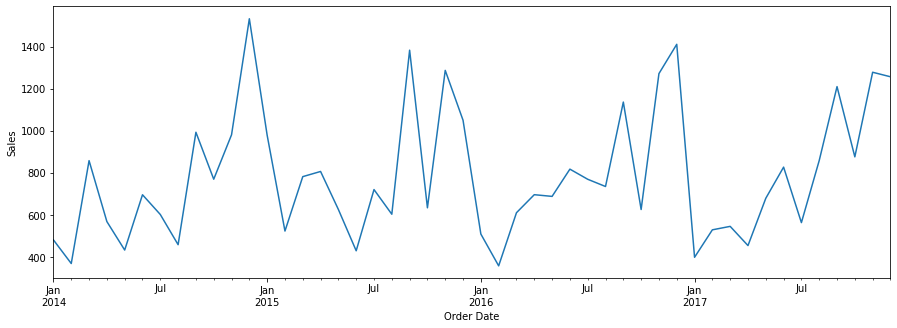

In [17]:
plt.figure()
y.plot(figsize=(15,5))
plt.xlabel('Order Date')
plt.ylabel('Sales')
plt.show()


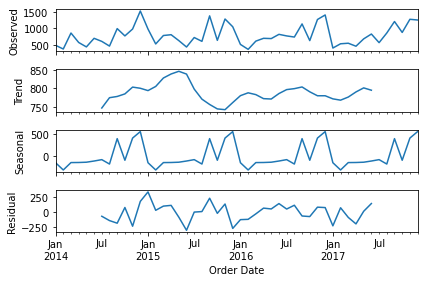

In [18]:
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show() 

In [19]:
# in AR I MA -> p,d,q 
p = d = q = range(0,2) # VALUE generators between [0,1] 
pdq = list(itertools.product(p,d,q))
print(pdq)

[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]


In [20]:
seasons = 12 
# repeatation of seasonal trend every 12 months
# LIST COMPREHENSION -> (0,0,0) -> (0,0,0,12)
seasonal_pdq = [   (x[0],x[1],x[2], seasons)  for x in pdq] # if x was (0,1,0), -> (0,1,0,12)
print('SARIMAX individual MODEL = {} X {}'.format(pdq[5], seasonal_pdq[0]))
print('SARIMAX individual MODEL = {} X {}'.format(pdq[5], seasonal_pdq[1]))
print('SARIMAX individual MODEL = {} X {}'.format(pdq[5], seasonal_pdq[2]))
print('SARIMAX individual MODEL = {} X {}'.format(pdq[5], seasonal_pdq[3]))
# here is an INDIVIDUAL MODEL -> WITH and WITHOUT SEASON 
# ALL SUCH PERMUTATIONS WILL BE EXHAUSTIVELY CREATED!!! 
# EVERY POSSIBLE COMBINATION HAS BEEN CREATED! 
# AN SARIMAX -> SEASONAL ARIMA EXHAUSTIVE 
# ALL possible algos with (seasonal_pdq) and without season (pdq)


SARIMAX individual MODEL = (1, 0, 1) X (0, 0, 0, 12)
SARIMAX individual MODEL = (1, 0, 1) X (0, 0, 1, 12)
SARIMAX individual MODEL = (1, 0, 1) X (0, 1, 0, 12)
SARIMAX individual MODEL = (1, 0, 1) X (0, 1, 1, 12)


In [21]:
min_pdq = (999,999,999)
min_spdq = (999,999,999,12)
min_AIC = 999
for param in pdq:
  for sparam in seasonal_pdq:
    try:
      model = sm.tsa.statespace.SARIMAX(y, order=param, seasonal_order=sparam, enforce_stationarity=False)
      predictions = model.fit()
      print('Model={}X{}. AIC= {}'.format(param, sparam, predictions.aic))
      if(predictions.aic < min_AIC):
        min_pdq = param
        min_spdq = sparam
        min_AIC = predictions.aic
    except Exception as e:
      print(e)
      continue

print('**** Smallest PDQ,SPDQ is *****')
print(min_AIC)
print(min_pdq)
print(min_spdq)


Model=(0, 0, 0)X(0, 0, 0, 12). AIC= 769.0817523205916
Model=(0, 0, 0)X(0, 0, 1, 12). AIC= 548.1772347587046
Model=(0, 0, 0)X(0, 1, 0, 12). AIC= 477.71701309202774
maxlag should be < nobs
Model=(0, 0, 0)X(1, 0, 0, 12). AIC= 497.2314433418337
Model=(0, 0, 0)X(1, 0, 1, 12). AIC= 478.3653805749645
Model=(0, 0, 0)X(1, 1, 0, 12). AIC= 318.0047199116341
maxlag should be < nobs
Model=(0, 0, 1)X(0, 0, 0, 12). AIC= 720.9252270739973
Model=(0, 0, 1)X(0, 0, 1, 12). AIC= 514.7587049639892
Model=(0, 0, 1)X(0, 1, 0, 12). AIC= 466.5556513479083
maxlag should be < nobs
Model=(0, 0, 1)X(1, 0, 0, 12). AIC= 498.8314925544705
Model=(0, 0, 1)X(1, 0, 1, 12). AIC= 467.1039211192387
Model=(0, 0, 1)X(1, 1, 0, 12). AIC= 319.9884876946219
maxlag should be < nobs
Model=(0, 1, 0)X(0, 0, 0, 12). AIC= 677.894766859465
Model=(0, 1, 0)X(0, 0, 1, 12). AIC= 488.7012043020711
Model=(0, 1, 0)X(0, 1, 0, 12). AIC= 486.63785671879367
maxlag should be < nobs
Model=(0, 1, 0)X(1, 0, 0, 12). AIC= 497.78896630044073
Model=(0, 1, 0

In [22]:
model = sm.tsa.statespace.SARIMAX(y, order=min_pdq, seasonal_order= min_spdq, enforce_stationarity=False)
# (0, 1, 0)X(1, 0, 1, 12)
model2 = sm.tsa.statespace.SARIMAX(y, order=(0, 1, 0), seasonal_order= (1, 0, 1, 12), enforce_stationarity=False)
results = model.fit()
results2 = model2.fit()
# we've taken 2 models so that we can compare their predictions 
results.summary() #.tables[1]  # AIC => needs to be lowest 
# results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 12)   Log Likelihood                -145.301
Date:                            Wed, 06 Apr 2022   AIC                            298.602
Time:                                    13:35:49   BIC                            302.966
Sample:                                01-01-2014   HQIC                           299.630
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1280      0.276      0.464      0.643      -0.412       0.669
ma.L1         -0.9998      0.450     -2.223      0.026      -1.881      -0.118
ar.S.L12      -0.2811      0.154     -1.826      0.068      -0.583       0.021
sigma2      3.028e+04   1.49e-05   2.04e+09      0.000    3.03e+04    3.03e+04
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):                 0.77
Prob(Q):                               nan   Prob(JB):                         0.68
Heteroskedasticity (H):               0.67   Skew:                            -0.22
Prob(H) (two-sided):                  0.61   Kurtosis:                         2.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.69e+24. Standard errors may be unstable.
"""

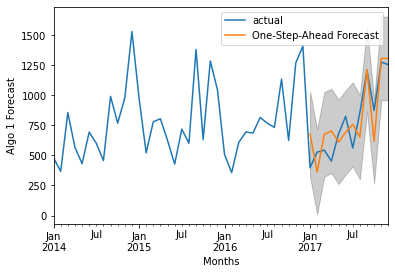

In [23]:
# let's check the actual predictions and plot them 

pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
pred2 = results2.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred2_ci = pred2.conf_int()
ax = y['2014':].plot(label='actual') # ACTUAL DATA PLOT
pred.predicted_mean.plot(ax=ax, label='One-Step-Ahead Forecast')
# there is always a tolerance or error kernel(region) surrounding the forecast
# +- region within which mistakes are acceptable 
# THIS TOLERANCE REGION is also called CONFIDENCE INTERVAL 
ax.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], color='k', alpha=0.2)
# BASE LINE-> index, lower confidence limit, upper confidence limit
ax.set_xlabel('Months')
ax.set_ylabel('Algo 1 Forecast')
plt.legend()
plt.show() 

